# Imports

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

%reload_ext autoreload
%autoreload 2
import sys
#%matplotlib notebook
%matplotlib inline
#from bokeh.io import output_notebook

from typing import Dict, List, Callable, Tuple, Union, Sequence


sys.path.append('../../')
sys.path.append('../../wsi_processing_pipeline/')
sys.path.append('../../wsi_processing_pipeline/tile_extraction/')
import tile_extraction
from tile_extraction import tiles, util, slide
import wsi_processing_pipeline
from wsi_processing_pipeline import shared
from wsi_processing_pipeline.shared import roi
from wsi_processing_pipeline.cytomine import util_cytomine


import os
import pandas
import pandas as pd
import numpy
import numpy as np
import torch, torchvision
import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]

import PIL
from PIL import Image

import fastai
from fastai import vision
from fastai.vision.all import *
import matplotlib.pyplot as plt
import matplotlib.patches
from itertools import groupby
from tqdm.notebook import tqdm
import cv2
import random
import scipy.io
import json
import pickle
import math
import multiprocessing
import openslide
import json

seed = 19
np.random.seed(seed)

import cytomine
from cytomine import Cytomine
from cytomine.models import CurrentUser, Project, ProjectCollection, ImageInstanceCollection, AnnotationCollection
from cytomine.models import Annotation, AnnotationTerm
from cytomine.models.ontology import Ontology, Term, RelationTerm, TermCollection, OntologyCollection


import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]
from typing import List
import shapely
from shapely import wkt
from shapely.affinity import affine_transform


PATH = Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/')
PATH_DNET = PATH/'DNETs'
PATH_DNET_WSIS = PATH_DNET/'wsis'
PATH_GANGLIOGLIOMA = PATH/'Ganglioglioma'

wsi_paths_dnets = fastai.data.transforms.get_files(path=PATH_DNET_WSIS, extensions=['.ndpi'])
wsi_paths_ganglioglioma = fastai.data.transforms.get_files(path=PATH_GANGLIOGLIOMA, extensions=['.ndpi'])
wsi_paths = list(wsi_paths_dnets+wsi_paths_ganglioglioma)

# connect with cytomine

In [3]:
creds_path = Path("../credentials.json")
j = json.load(open(creds_path))

host = j['host']
public_key = j['public_key']
private_key = j['private_key']

In [4]:
with Cytomine(host, public_key, private_key) as cytomine_connection:
    # We are connected !
    me = CurrentUser().fetch()

    # It will print your username, that has been retrieved from Cytomine.
    print(me.username)

[2022-05-20 11:46:44,834][INFO] [GET] [currentuser] CURRENT USER - 58 : admin | 200 OK
[2022-05-20 11:46:44,847][INFO] [GET] [currentuser] CURRENT USER - 58 : admin | 200 OK
admin


# fetch projects and associated images

In [5]:
projects = ProjectCollection().fetch()

[2022-05-20 11:46:48,170][INFO] [GET] [project collection] 2 objects | 200 OK


In [6]:
project_names = ['DNET', 'Gangliogliom']
projects_filtered = []
for p in projects:
    if(p.name in project_names):
        projects_filtered.append(p)
        print(p.id)

375
397


In [7]:
images_dict = {}
for pn in project_names:
    for p in projects_filtered:
        if(p.name == pn):
            images_dict[pn] = ImageInstanceCollection().fetch_with_filter("project", p.id)

[2022-05-20 11:46:48,797][INFO] [GET] [imageinstance collection] 3 objects | 200 OK
[2022-05-20 11:46:48,817][INFO] [GET] [imageinstance collection] 3 objects | 200 OK


In [8]:
images_list = []
for p in projects_filtered:
    for i in ImageInstanceCollection().fetch_with_filter("project", p.id):
        images_list.append(i)

[2022-05-20 11:46:50,138][INFO] [GET] [imageinstance collection] 3 objects | 200 OK
[2022-05-20 11:46:50,159][INFO] [GET] [imageinstance collection] 3 objects | 200 OK


In [9]:
for i in images_dict['DNET']:
    print(i.filename)
print('--------------')   
for i in images_dict['Gangliogliom']:
    print(i.filename)

casus12.ndpi
casus18.ndpi
casus13.ndpi
--------------
N2-16-II1.ndpi
538-90.ndpi
casus26.ndpi


# export rois

In [10]:
json_paths_dnets = fastai.data.transforms.get_files(path=PATH_DNET, extensions=['.json'])
json_paths_ganglioglioma = fastai.data.transforms.get_files(path=PATH_GANGLIOGLIOMA, extensions=['.json'])
json_paths = list(json_paths_dnets+json_paths_ganglioglioma)

def get_json_path_for_wsi(wsi_path:pathlib.Path, json_paths:List[pathlib.Path])->pathlib.Path:
    """
    Arguments:
        wsi_path: path to whole-slide image
        json_paths: a list of paths to all json files, which contain the coordinates of region of interests of the
                    corresponding wsi
    Returns:
        Returns path of corresponding json file or raises FileNotFoundError, if json file cannot be found in json_paths
    """
    wsi_name = wsi_path.stem
    for jp in json_paths:
        if(wsi_name == jp.stem):
            return jp
    
    raise FileNotFoundError(f'json file could not be found for {wsi_path}')

        
def get_rois_from_wsi_path(wsi_path:pathlib.Path, json_paths:List[pathlib.Path])\
                            ->List[wsi_processing_pipeline.shared.roi.RegionOfInterestPolygon]:
    json_path = get_json_path_for_wsi(wsi_path=wsi_path, json_paths=json_paths)
    return roi.get_list_of_RegionOfInterestPolygon_from_json(json_path=json_path)

wsi_paths_all_without_corresponding_json_file = []
wsi_path_to_json_path = {}

for wp in wsi_paths:
    try:
        json_path = get_json_path_for_wsi(wsi_path=wp, json_paths=json_paths)
        wsi_path_to_json_path[wp] = json_path
        
        #if(json_path in duplicates):
        #if(json_path in jps):
        #    print(wp)
        #jps.append(json_path)
    except FileNotFoundError:
        wsi_paths_all_without_corresponding_json_file.append(wp)

wsi_paths_with_json_files = list(wsi_path_to_json_path.keys())

wsi_path_to_rois = {}
for wp in wsi_paths_with_json_files:
    wsi_path_to_rois[wp] = get_rois_from_wsi_path(wsi_path=wp, json_paths=json_paths)

In [27]:
for i in images_list:
    ##
    # delete existing annotations
    ##
    util_cytomine.delete_all_annotations(image=i)

[2022-05-20 12:26:58,558][INFO] [GET] [annotation collection] 7 objects | 200 OK
[2022-05-20 12:26:58,608][INFO] [DELETE] [annotation] 20333 | 200 OK
[2022-05-20 12:26:58,648][INFO] [DELETE] [annotation] 20320 | 200 OK
[2022-05-20 12:26:58,704][INFO] [DELETE] [annotation] 20307 | 200 OK
[2022-05-20 12:26:58,745][INFO] [DELETE] [annotation] 20294 | 200 OK
[2022-05-20 12:26:58,787][INFO] [DELETE] [annotation] 20281 | 200 OK
[2022-05-20 12:26:58,826][INFO] [DELETE] [annotation] 20268 | 200 OK
[2022-05-20 12:26:58,869][INFO] [DELETE] [annotation] 20255 | 200 OK
[2022-05-20 12:26:58,884][INFO] [GET] [annotation collection] 5 objects | 200 OK
[2022-05-20 12:26:58,922][INFO] [DELETE] [annotation] 20398 | 200 OK
[2022-05-20 12:26:58,968][INFO] [DELETE] [annotation] 20385 | 200 OK
[2022-05-20 12:26:59,004][INFO] [DELETE] [annotation] 20372 | 200 OK
[2022-05-20 12:26:59,042][INFO] [DELETE] [annotation] 20359 | 200 OK
[2022-05-20 12:26:59,083][INFO] [DELETE] [annotation] 20346 | 200 OK
[2022-05-2

In [28]:
for i in images_list:
    ##
    # delete existing annotations
    ##
    #util_cytomine.delete_all_annotations(image=i)
    
    ##
    # add rois
    ##
    print(i.filename)
    wsi_path = util_cytomine.get_wsi_path_from_cytomine_image_instance(i=i, wsi_paths=wsi_paths)
    rois = wsi_path_to_rois[wsi_path]
    wsi = openslide.open_slide(str(wsi_path))
    project = util_cytomine.get_project_for_image(image=i, projects=projects_filtered)
    for r in rois:
        poly = r.get_shapely_polygon_adjusted_to_origin_upper_left(wsi_height=wsi.dimensions[1], wsi_height_level=0)
        anno = Annotation(location=poly.wkt, id_image=i.id).save()
        util_cytomine.add_terms_to_annotation(annotation=anno, terms = r.labels+['roi'], ontology_id=project.ontology)

casus12.ndpi
[2022-05-20 12:27:13,282][INFO] [POST] [annotation] 21164 | 200 OK
[2022-05-20 12:27:13,310][INFO] [GET] [ontology collection] 2 objects | 200 OK
[2022-05-20 12:27:13,326][INFO] [GET] [term collection] 4 objects | 200 OK
[2022-05-20 12:27:13,352][INFO] [POST] [annotationterm] Annotation 21164 - Term 13169 | 200 OK
[2022-05-20 12:27:13,383][INFO] [POST] [annotation] 21177 | 200 OK
[2022-05-20 12:27:13,411][INFO] [GET] [ontology collection] 2 objects | 200 OK
[2022-05-20 12:27:13,427][INFO] [GET] [term collection] 4 objects | 200 OK
[2022-05-20 12:27:13,451][INFO] [POST] [annotationterm] Annotation 21177 - Term 13169 | 200 OK
[2022-05-20 12:27:13,481][INFO] [POST] [annotation] 21190 | 200 OK
[2022-05-20 12:27:13,509][INFO] [GET] [ontology collection] 2 objects | 200 OK
[2022-05-20 12:27:13,525][INFO] [GET] [term collection] 4 objects | 200 OK
[2022-05-20 12:27:13,552][INFO] [POST] [annotationterm] Annotation 21190 - Term 13169 | 200 OK
[2022-05-20 12:27:13,579][INFO] [POST] 

# fetch rois

In [20]:
image_instance_id_to_rois = {}
image_name_to_rois = {}
for i in images_list:
    wsi_path = util_cytomine.get_wsi_path_from_cytomine_image_instance(i=i, wsi_paths=wsi_paths)
    rois = util_cytomine.get_image_instance_annotations_as_rois(image=i, wsi_path=wsi_path)
    image_instance_id_to_rois[i.id] = rois
    image_name_to_rois[i.filename] = rois

[2022-05-20 11:49:32,793][INFO] [GET] [annotation collection] 7 objects | 200 OK
[2022-05-20 11:49:32,805][INFO] [GET] [annotation] 20333 | 200 OK
[2022-05-20 11:49:32,817][INFO] [GET] [project] 375 : DNET | 200 OK
[2022-05-20 11:49:32,832][INFO] [GET] [term collection] 4 objects | 200 OK
[2022-05-20 11:49:32,846][INFO] [GET] [annotation] 20320 | 200 OK
[2022-05-20 11:49:32,857][INFO] [GET] [project] 375 : DNET | 200 OK
[2022-05-20 11:49:32,874][INFO] [GET] [term collection] 4 objects | 200 OK
[2022-05-20 11:49:32,890][INFO] [GET] [annotation] 20307 | 200 OK
[2022-05-20 11:49:32,899][INFO] [GET] [project] 375 : DNET | 200 OK
[2022-05-20 11:49:32,917][INFO] [GET] [term collection] 4 objects | 200 OK
[2022-05-20 11:49:32,930][INFO] [GET] [annotation] 20294 | 200 OK
[2022-05-20 11:49:32,939][INFO] [GET] [project] 375 : DNET | 200 OK
[2022-05-20 11:49:32,955][INFO] [GET] [term collection] 4 objects | 200 OK
[2022-05-20 11:49:32,970][INFO] [GET] [annotation] 20281 | 200 OK
[2022-05-20 11:49

In [26]:
i = images_list[0]
rois = image_instance_id_to_rois[i.id]
r= rois[0]
r.labels

['roi']

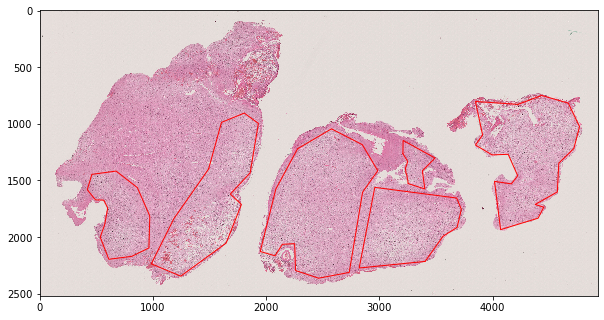

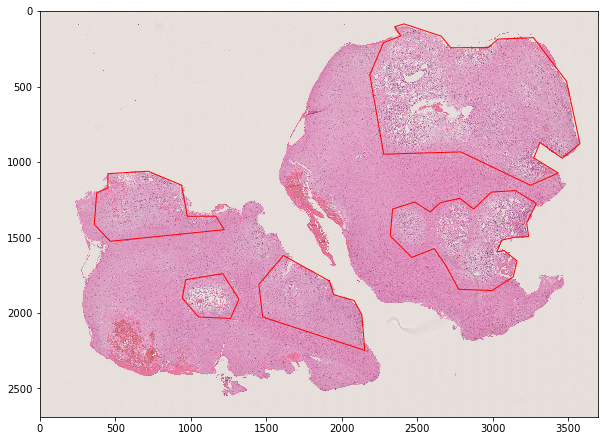

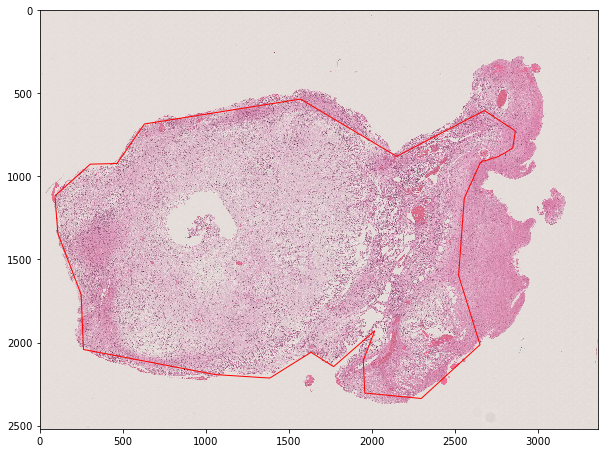

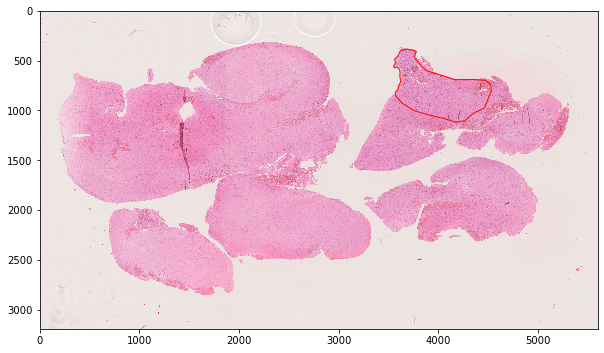

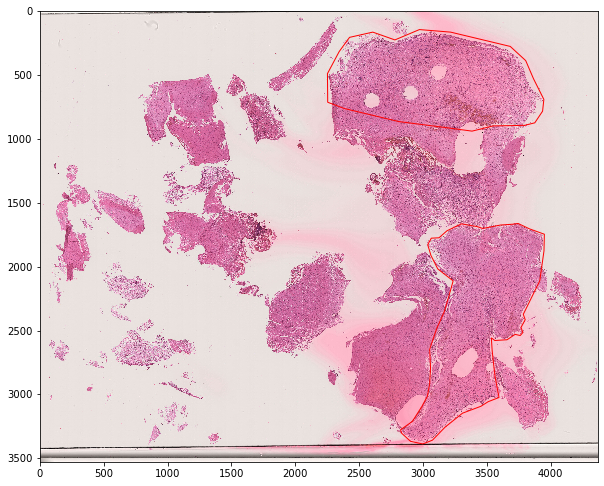

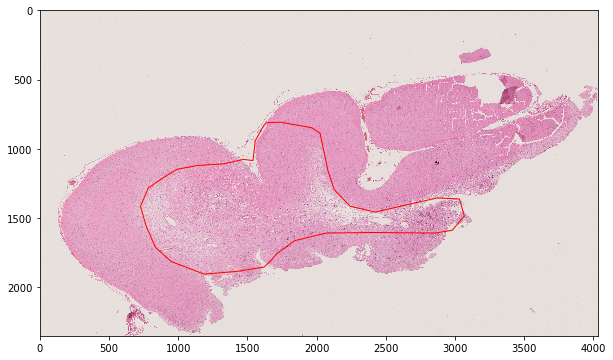

In [21]:
for i in images_list:
    wsi_path = util_cytomine.get_wsi_path_from_cytomine_image_instance(i=i, wsi_paths=wsi_paths)
    util.show_wsi_with_rois(wsi_path, image_instance_id_to_rois[i.id])

# tilesummaries

In [30]:
wps = [util_cytomine.get_wsi_path_from_cytomine_image_instance(i,wsi_paths) for i in images_list]
tilesummaries = tiles.WsisToTilesParallel(wsi_paths=wps,
                                          tile_height=1024, 
                                          tile_width=1024, 
                                          tile_scoring_function=tiles.score_tile_2,
                                          tile_score_thresh=0.2, 
                                          level=0, 
                                          wsi_path_to_rois=wsi_path_to_rois,
                                          minimal_tile_roi_intersection_ratio=0.9, 
                                          verbose=False, 
                                          grids_per_roi=1)

  0%|          | 0/6 [00:00<?, ?it/s]

347
1121
1767
1876
2607
3335
IndexError in WsiToTiles for the rectangle: (ul: (x:20782.55, y:33966.55), ur: (x:21806.55, y:33966.55), lr: (x:21806.55, y:34990.55), ll: (x:20782.55, y:34990.55))


 17%|█▋        | 1/6 [00:49<04:05, 49.13s/it]

IndexError in WsiToTiles for the rectangle: (ul: (x:112880.19, y:89027.13), ur: (x:113904.19, y:89027.13), lr: (x:113904.19, y:90051.13), ll: (x:112880.19, y:90051.13))
IndexError in WsiToTiles for the rectangle: (ul: (x:106736.19, y:99267.13), ur: (x:107760.19, y:99267.13), lr: (x:107760.19, y:100291.13), ll: (x:106736.19, y:100291.13))


 50%|█████     | 3/6 [02:48<02:42, 54.19s/it]

IndexError in WsiToTiles for the rectangle: (ul: (x:78217.11, y:24052.81), ur: (x:79241.11, y:24052.81), lr: (x:79241.11, y:25076.81), ll: (x:78217.11, y:25076.81))


 67%|██████▋   | 4/6 [03:31<01:41, 50.73s/it]

IndexError in WsiToTiles for the rectangle: (ul: (x:102564.45, y:39761.63), ur: (x:103588.45, y:39761.63), lr: (x:103588.45, y:40785.63), ll: (x:102564.45, y:40785.63))
IndexError in WsiToTiles for the rectangle: (ul: (x:103588.45, y:45905.63), ur: (x:104612.45, y:45905.63), lr: (x:104612.45, y:46929.63), ll: (x:103588.45, y:46929.63))
IndexError in WsiToTiles for the rectangle: (ul: (x:141561.51, y:24015.82), ur: (x:142585.51, y:24015.82), lr: (x:142585.51, y:25039.82), ll: (x:141561.51, y:25039.82))
IndexError in WsiToTiles for the rectangle: (ul: (x:129273.51, y:26063.82), ur: (x:130297.51, y:26063.82), lr: (x:130297.51, y:27087.82), ll: (x:129273.51, y:27087.82))
IndexError in WsiToTiles for the rectangle: (ul: (x:12125.130000000001, y:65213.82), ur: (x:13149.130000000001, y:65213.82), lr: (x:13149.130000000001, y:66237.82), ll: (x:12125.130000000001, y:66237.82))


100%|██████████| 6/6 [04:41<00:00, 40.81s/it]

# learner and predictions

In [31]:
from fastai.learner import *

In [32]:
from wsi_processing_pipeline.shared.util_shared import get_x, get_y, split

In [33]:
exported_learner_path = PATH/Path('models/1-resnet50/dnet_vs_gg_resnet-1-resnet50.pkl'); exported_learner_path

Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/models/1-resnet50/dnet_vs_gg_resnet-1-resnet50.pkl')

In [34]:
learner = load_learner(fname=exported_learner_path)

In [35]:
for ts in tqdm(tilesummaries):
    for t in tqdm(ts.top_tiles()):
        t.predictions_fastai_inference = learner.predict(t)

# export tiles with predictions to cytomine

In [207]:
from wsi_processing_pipeline.cytomine.util_cytomine import get_cytomine_image_instance_for_wsi_name
from wsi_processing_pipeline.cytomine.util_cytomine import get_project_for_image                                        

In [186]:
for ts in tqdm(tilesummaries):
    image = get_cytomine_image_instance_for_wsi_name(image_instances=images_list,wsi_name=ts.wsi_path.name)
    
    ###
    # delete all already existing tile annotations
    ###
    annotations = AnnotationCollection()
    annotations.image = image.id
    annotations.fetch()
    for a in annotations:
        if()
            a.delete()
    
    for t in tqdm(ts.top_tiles()):
        pass

In [177]:
ts = tilesummaries[0]
t = ts.top_tiles()[0]
t_pil = t.get_pil_image()
t_preds = learner.predict(t)
t_preds

((#1) ['Ganglioglioma'], tensor([False,  True]), tensor([0.0013, 0.9987]))